# Principal Component Analysis (PCA) and Data Visualization

### Author: Hugo Lancery - Avery Cloutier

---

## Overview

This notebook explores **Principal Component Analysis (PCA)**, an essential dimensionality reduction technique, and demonstrates its application on real-world datasets. Through various visualizations and statistical tools, we aim to:

- **Reduce high-dimensional data** into 2D or 3D for better interpretability.
- **Visualize the most significant components** that explain the largest variance.
- **Compare PCA with other techniques** like t-SNE and UMAP for better insights.

---

## Key Sections

1. **Data Preprocessing**
    - Centering and scaling the data using **mean normalization** and **variance scaling**.
    - Visualizing the correlation matrix.
  
2. **Principal Component Analysis (PCA)**
    - Eigenvalue decomposition and explained variance.
    - Visualization of data projected onto the first two principal components.
  
3. **Advanced Visualization Techniques**
    - Comparing results with **t-SNE** and **UMAP**.
    - 2D and 3D scatter plots.

4. **Discussion & Conclusion**
    - Interpretation of results.
    - Choosing the right dimensionality reduction method based on data characteristics.

---

## Objectives

- **Understand the theory behind PCA** and how it extracts essential patterns from high-dimensional data.
- **Learn how to interpret PCA results** through explained variance and component loadings.
- **Apply PCA to real datasets** and visualize the reduced dimensions.
- **Compare PCA to other dimensionality reduction techniques** for a comprehensive analysis.

---

## Tools & Libraries

- **Python** for data manipulation and processing.
- **NumPy** and **Pandas** for numerical operations and dataset handling.
- **Matplotlib** and **Seaborn** for data visualization.
- **Scikit-learn** for applying PCA, t-SNE, and UMAP.

---

*Let’s dive into the world of dimensionality reduction and data visualization!*



In [102]:
from collections import defaultdict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as Ldisc
from sklearn.model_selection import train_test_split as ttrain
from sklearn.preprocessing import StandardScaler as scaleprep
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score as f1eval
from sklearn.preprocessing import LabelEncoder
from pandas.errors import PerformanceWarning
from itertools import combinations, product
from sklearn.metrics import r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import warnings
import random
import json



warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=PerformanceWarning)
pd.options.mode.chained_assignment = None

---

**Data imported from NASA saved on the Github Repo**


In [103]:
url_CSV = 'https://github.com/LanceryH/NASA-hackathon-2024/raw/refs/heads/main/data_SEDAC.csv'
url_JSON = 'https://github.com/LanceryH/NASA-hackathon-2024/raw/refs/heads/main/country_continent.json'

In [104]:
data_brut = pd.read_csv(url_CSV, encoding='ISO-8859-1')
data_brut['gdp'] = pd.to_numeric(data_brut['GDPPC05'], errors='coerce')
data_brut = data_brut.dropna(subset=['gdp'])
data_class_country = requests.get(url_JSON).json()
df = data_brut.copy()


In [105]:
correl_vals = []

# calculate Pearson's correlation coefficient
for col in tqdm([col for col in df.columns if "gdp" not in col.lower()], desc="Calculating Pearson Correlation Coefficients"):
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        temp_df = df[['gdp', col]].dropna()

        if len(temp_df) > 10:
            # Calculate Pearson correlation between GDP and the column
            correl_matrix = np.corrcoef(temp_df['gdp'], temp_df[col])
            correl = correl_matrix[0, 1]  # Extract the correlation value

            correl_vals.append((col, correl))
    except Exception as e:
        print(f"Error processing column {col}: {e}")

# sort by absolute correlation (highest absolute correlation values first)
top_20_cols = sorted(correl_vals, key=lambda x: abs(x[1]), reverse=True)[:20]

print("Final Results of 1st Step of Analysis:")
for col, correl in top_20_cols:
    print(f"Column: {col}, Pearson Correlation: {correl:.4f}")



Calculating Pearson Correlation Coefficients: 100%|██████████| 458/458 [00:00<00:00, 544.31it/s]

Final Results of 1st Step of Analysis:
Column: MPHONE, Pearson Correlation: 0.9020
Column: ECOLFOOT, Pearson Correlation: 0.8845
Column: CAP_ST, Pearson Correlation: 0.8666
Column: ECONSZSC, Pearson Correlation: 0.8655
Column: WEFGOV, Pearson Correlation: 0.8358
Column: EFPC, Pearson Correlation: 0.8352
Column: NTLWTHSC, Pearson Correlation: 0.8313
Column: COMSC, Pearson Correlation: 0.8296
Column: CAP, Pearson Correlation: 0.8195
Column: CAP_GOV, Pearson Correlation: 0.8096
Column: CAP_PRI, Pearson Correlation: 0.8050
Column: INNOV, Pearson Correlation: 0.7992
Column: DAI, Pearson Correlation: 0.7991
Column: GOVEFF, Pearson Correlation: 0.7911
Column: RECYCLE, Pearson Correlation: 0.7882
Column: GRAFT, Pearson Correlation: 0.7849
Column: RDEXP, Pearson Correlation: 0.7824
Column: CARBFOOT, Pearson Correlation: 0.7773
Column: FLRAREA, Pearson Correlation: 0.7667
Column: HWI, Pearson Correlation: 0.7658


In [106]:
# step to create 'gdp_class' column based on quantiles
quantile_80 = df['gdp'].quantile(0.80)
quantile_20 = df['gdp'].quantile(0.20)

# create 'gdp_class' based on upper 80% and lower 20%
df['gdp_class'] = df['gdp'].map(lambda x: 1 if x >= quantile_80 else (0 if x <= quantile_20 else np.nan))

# drop any rows where 'gdp_class' is missing
df = df.dropna(subset=['gdp_class'])

# combined score function (as per the previous part one)
def combined_score(r2, correl, r2_weight=0.5, correl_weight=0.5):
    return r2_weight * r2 + correl_weight * abs(correl)

# combining R² and correlation
combined_vals = []

for col in tqdm([col for col in df.columns if "gdp" not in col.lower()], desc="Calculating R² and Correlation Scores"):
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        temp_df = df[['gdp', col]].dropna()

        if len(temp_df) > 10:
            # Calculate R²
            X = temp_df[[col]]
            y = temp_df['gdp']

            model = LinearRegression()
            model.fit(X, y)

            preds = model.predict(X)
            r2 = r2_score(y, preds)

            # Pearson correlation
            correl_matrix = np.corrcoef(temp_df['gdp'], temp_df[col])
            correl = correl_matrix[0, 1]

            combined = combined_score(r2, correl)
            combined_vals.append([col, combined, r2, correl])
    except Exception as e:
        print(f"Error processing column {col}: {e}")

# sort by combined score to pull top 20
top_20_cols = sorted(combined_vals, key=lambda x: x[1], reverse=True)[:20]

print("Final Results of Combined R² and Correlation Scores:")
for col, combined, r2, correl in top_20_cols:
    print(f"Column: {col}, Combined Score: {combined:.4f}, R²: {r2:.4f}, Correlation: {correl:.4f}")

Calculating R² and Correlation Scores: 100%|██████████| 458/458 [00:02<00:00, 189.83it/s]

Final Results of Combined R² and Correlation Scores:
Column: FLRAREA, Combined Score: 0.9360, R²: 0.9152, Correlation: 0.9567
Column: MPHONE, Combined Score: 0.9235, R²: 0.8989, Correlation: 0.9481
Column: CAP_ST, Combined Score: 0.9111, R²: 0.8827, Correlation: 0.9395
Column: ENVHEALEPI, Combined Score: 0.9102, R²: 0.8815, Correlation: 0.9389
Column: ECOLFOOT, Combined Score: 0.8664, R²: 0.8247, Correlation: 0.9081
Column: EPI2006, Combined Score: 0.8578, R²: 0.8136, Correlation: 0.9020
Column: VUL_HEA, Combined Score: 0.8562, R²: 0.8115, Correlation: 0.9008
Column: ECONSZSC, Combined Score: 0.8548, R²: 0.8098, Correlation: 0.8999
Column: CAP, Combined Score: 0.8443, R²: 0.7963, Correlation: 0.8924
Column: NTLWTHSC, Combined Score: 0.8369, R²: 0.7868, Correlation: 0.8870
Column: CAP_GOV, Combined Score: 0.8366, R²: 0.7864, Correlation: 0.8868
Column: COMSC, Combined Score: 0.8317, R²: 0.7802, Correlation: 0.8833
Column: DAI, Combined Score: 0.8296, R²: 0.7774, Correlation: 0.8817
Colu

---

**Rearrange the dataset to match our needs**

In [109]:
index = np.array(top_20_cols)[:,0]
# Selection of the best 20 correlated rows
data_SEDAC = data_brut.pivot_table(index=None,
                                   columns='Country_Standard',
                                   values=np.array(top_20_cols)[:,0],
                                   aggfunc='first')
# Replace blank space in the dataset to avoid errors
data_SEDAC = data_SEDAC.replace(" ", 0, regex=True)
# Remap of the dataset (matrix Transpose) to put the continent column as the header
data_SEDAC.columns = data_SEDAC.columns.map(data_class_country)

Creates values that will contains part of the dataset

In [110]:
labels_columns = data_SEDAC.columns.to_numpy()
labels_row = data_SEDAC.index.to_numpy()
R = data_SEDAC.to_numpy().astype("float").T

Lets first define all basic mathematic definition

In [111]:
def Average(X):
    """
    Calcul of the average of a matrix X
    """
    m = np.shape(X)[0]
    return(np.sum(X)/m)

def Variance(X):
    """
    Calcul of the variance of a matrix X
    """
    m = np.shape(X)[0]
    return(np.sum(((X-Average(X))**2)/(m-1)))

def Covariance(X, Y):
    """
    Calcul of the variance of a matrix X
    """
    m = np.shape(X)[0]
    return(np.sum((X-Average(X))*(Y-Average(Y)))*(1/m))

def Explained_variance(X):
    """
    Calcul of the eigenvalues of a covariance matrix X
    """
    return (X**2) / np.sum(X**2)

def Correlation(X, Y):
    """
    Calcul of the correlation between two matrices X and Y
    """
    Cori = []
    m, n = np.shape(X)
    for i in range(n):
        Corik = Covariance(X[:, i], Y) / (Variance(X[:, i])*Variance(Y)) ** 0.5
        Cori.insert(i, Corik)
    return Cori

In [112]:
def Centered_reduced(R):  # Calcul de la matrice centrée réduite de R
    m, n = np.shape(R)  # shape de la matrice d'entrée
    Rcr = np.zeros((m, n))  # matrice de zéros de taille (m,n)
    for i in range(n):
        # calcul de chaque colonne de la futur matrice centrée réduite
        Rcr[:, i] = (R[:, i]-Average(R[:, i])) / np.sqrt(Variance(R[:, i]))
    return (Rcr)

def Pojection(R, k):  # Calcul l'Average
    X = Centered_reduced(R)  # On centre réduit notre matrice d'entrée
    m, n = np.shape(X)  # on stock la forme m,n de la matrice centrée reduite
    u, s, vt = np.linalg.svd(X)
    v = vt.T  # transpose vt
    projk = []
    for i in range(k):
        vk = v[:, i].reshape(len(v), 1)  # on récupère vk la colonne i de v
        Yk = X@vk  # on calcul Yk avec X et vk
        uj = u[:, i].reshape(len(u), 1)  # on récupère uj la colonne i de u
        # on insert dans projk la variance de Yk*uj
        projk.insert(i, Variance(Yk)*uj)
    # on utilise np.block pour construire notre matrice finale projk
    projk = np.block([projk[i] for i in range(k)])
    return(projk)

def Correlation_proj(R, k):  # Ensemble des corélation de Yk et Xi
    X = Centered_reduced(R)
    Y = Pojection(X, k)
    Cori = []
    for i in range(k):
        # on applique la fonction Cori sur X et la colonne i de Y
        Corik = Correlation(X, Y[:, i])
        Cori.insert(i, Corik)  # On stock le résultat final
    return (Cori)

In [113]:
R_cr = Centered_reduced(R)
u, s, vt = np.linalg.svd(R_cr)
m, k = R_cr.shape
E_v = Explained_variance(s)  # Calculate explained variance


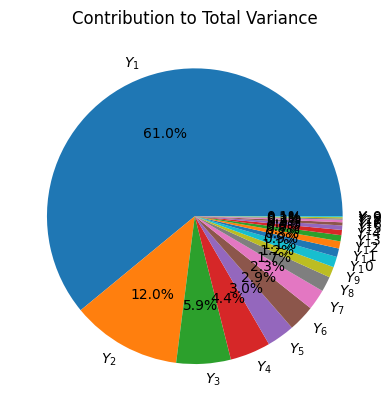

In [114]:
ind = [f'$Y_{i+1}$' for i in range(k)]  # Principal component labels

plt.figure()
plt.pie(E_v, labels=ind, autopct='%.1f%%')
plt.title('Contribution to Total Variance')
plt.show()

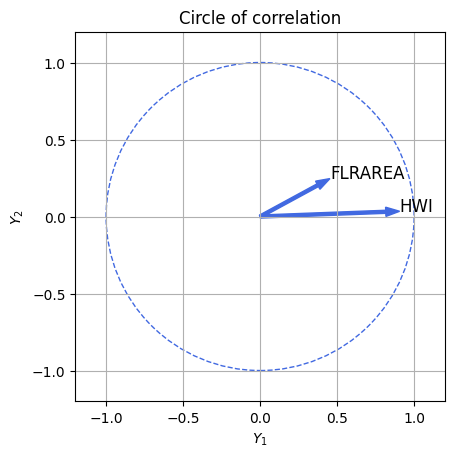

In [115]:
Corx = Correlation_proj(R, 2)[0]
Cory = Correlation_proj(R, 2)[1]
# Tracé des flèches et de leur label
fig, ax = plt.subplots()
plt.grid()
plt.title('Circle of correlation')
plt.xlabel('$Y_{1}$')
plt.ylabel('$Y_{2}$')
draw_circle = plt.Circle((0.0, 0.0), 1.0, fill=False, ls='--', color='royalblue')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
ax.add_artist(draw_circle)
ax.set_aspect(1)
for i in range(10,12):
    plt.arrow(0, 0, Corx[i], Cory[i], width=0.02,
              length_includes_head=True, color='royalblue')
    plt.annotate(text=labels_row[i], xy=(
        Corx[i], Cory[i]),  fontsize=12)

plt.show()

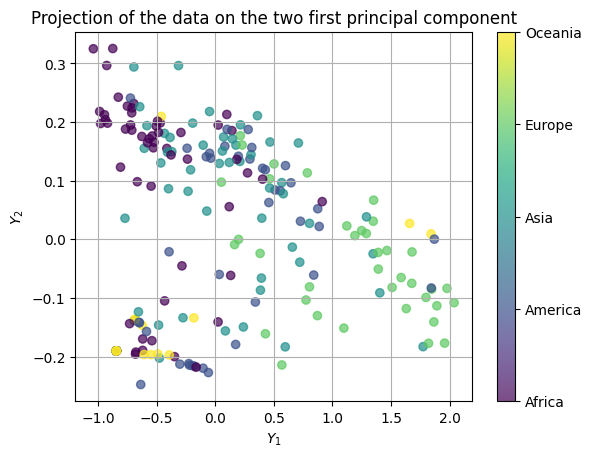

In [116]:
Proj = Pojection(R_cr, 2)

# Encoder les labels en numéros si ce sont des catégories textuelles
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_columns)
# Tracé des données projetées dans l'espace des composantes principales
plt.figure()
scatter = plt.scatter(Proj[:, 0], Proj[:, 1], c=labels_encoded, cmap='viridis', alpha=0.7)
plt.xlabel('$Y_1$')
plt.ylabel('$Y_2$')
plt.title('Projection of the data on the two first principal component')
plt.grid(True)
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)  # Afficher les labels originaux dans la barre de couleur
plt.show()

In [117]:
from sklearn.manifold import TSNE

def TSNE2D_plot(R, labels_row, labels_columns):
    # Centrer et réduire la matrice R
    X = Centered_reduced(R)

    # Appliquer t-SNE pour une réduction de dimensions non linéaire
    tsne = TSNE(n_components=2, perplexity=20, n_iter=500)
    Y_tsne = tsne.fit_transform(X)

    # Encoder les labels en numéros si ce sont des catégories textuelles
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_columns)

    # Tracé en 2D des données projetées
    plt.figure()
    scatter = plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=labels_encoded, cmap='viridis', alpha=0.7)

    # Annoter le graphique
    plt.xlabel('$tSNE_1$')
    plt.ylabel('$tSNE_2$')
    plt.title('Projection des données en 2D avec t-SNE')
    plt.grid(True)

    # Ajouter une barre de couleurs
    cbar = plt.colorbar(scatter)
    cbar.set_ticks(np.arange(len(label_encoder.classes_)))
    cbar.set_ticklabels(label_encoder.classes_)

    plt.show()

# Utilisation de la fonction
# TSNE2D_plot(R, labels_row)


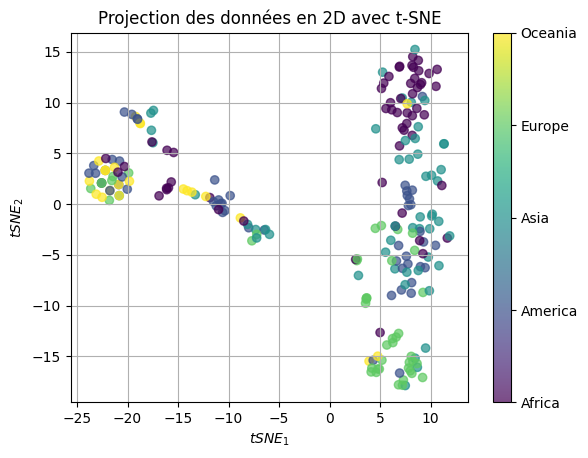

In [118]:
TSNE2D_plot(R, labels_row, labels_columns)